<H1>Pattern similarities</H1>

<P>We will compare similarities between the patterns in a network before (input) and after (output) the effect of inhibition.</P>

<P> If patterns of activity are less similar after inhibition, we will have pattern separation</P>

In [1]:
# load necessary modules
%pylab inline
import numpy as np
np.random.seed(0)

from scipy.stats import linregress

from inet.plots import plot_linear_fit
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [2]:
from inet import __version__
print(__version__)

0.0.11


<H2>Definition of random pattern $\boldsymbol{z}$</H2>

<P>A memory random pattern $\boldsymbol{z}$ is the representation of the activity of all the neurons in the network. It is a vector of lenght n, being n the total number of neurons in the network.</P>

$\boldsymbol{z}_i: i = \{0, 1, \cdots, n\},$


<P>The i-th element of the pattern is an independent random variable of probability a to be one when the neuron is active,  and zero if not (1-a). </P>

\begin{equation}
    \Pr(\boldsymbol{z}_i) = 
        \begin{cases}
        1, & \text{if} \ \ \boldsymbol{z}_i < a,\\
        0, & \text{if} \ \ \boldsymbol{z}_i \geq 1-a\\
        \end{cases}
\end{equation}


In [3]:
def randpattern(size, prob):
    """
    Creates a pattern of activities (ones) with a given probability. 
    Activity is 1 if the cell is active, zero otherwise.
    
    Parameters
    ----------
    size : ndarray
           vector size
    prob : float
            probability of having ones
    """
    z = np.zeros(size)
    mysize = int(size*prob)

    z[np.random.choice(size, mysize, replace=False)]=1 # without replacement. Thank you Clau!!!!
    
    return(z)

<H2>Vector norm</H2>

The most commonly encountered vector norm (often simply called "the norm" of a vector, or sometimes the magnitude of a vector) is the L2-norm, given by

\begin{equation}
\left\| \boldsymbol{z} \right\|_2 := \sqrt{z_1^2 + \cdots + z_n^2}.\end{equation}

In [4]:
z = randpattern(size=10, prob=0.5) # example for testing
mycount = list()
for _ in range(100):
    mycount.append(np.count_nonzero(randpattern(10,.5)) )
    
np.mean(mycount)

5.0

In [5]:
np.linalg.norm(z, ord=2) #norm2 of a vector

2.2360679774997898

In [6]:
np.linalg.norm([1,1],2) # must be sqrt(2)

1.4142135623730951

<H2>Definition of similarity</H2>

It is the cosine of the normalized dot product of two vectors. It is equivalent to the Pearson correlation coefficient.

$$
\text{similarity} = \cos(\theta) 
= {\mathbf{a} \cdot \mathbf{b} \over \|\mathbf{a}\|_2 \|\mathbf{b}\|_2} 
= \frac{ \sum\limits_{i=1}^{n}{a_i  b_i} }{ \sqrt{\sum\limits_{i=1}^{n}{a_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{b_i^2}} }    
$$ 

In [7]:
def similarity(a, b):
    """
    Compute cosine similarity between samples in A and B.

    Cosine similarity, or the cosine kernel, computes similarity as the
    normalized dot product of A and B:

     K(a, b) = <a, b> / (||a||*||b||)

    Parameters
    ----------
    a : ndarray .

    b : ndarray.

    """
    # dot product is scalar product
    return np.dot( a/np.linalg.norm(a), b/np.linalg.norm(b))

In [8]:
sim = list()
for _ in range(1000):
    a = randpattern(100,.5)
    b = randpattern(100,.5)
    sim.append(similarity(a, b))

print(np.mean(sim)) # get this analytically!

0.49964


In [9]:
similarity([1,0,1],[0,1,0]) # must be zero

0.0

<H2>Pattern separation</H2>

It is the devation in the similarities between the input vectors and the output vectors. If both
input and output vectors have the same similarity, then the relationship between their similarities is
linear. Any positive deviation from the identity line when plotting similarities of input and output vectors will
be because the output pattner are less similar than the input patterns.

In [10]:
def plot_pattern_separation(inputpattern, outputpattern, ax = None):
    """
    input pattern: a list containing tuples of input patterns
    outputpattern: a list containing tuples of outputpatterns
    
    Computes the linear regression of the similarity between paired patterns
    and plot a line with the 95% confident intervals.
    
    Returns:
    
    pattern_completion: int
        0 if no pattern completion.
    """
    
    if ax is None:
        ax = plt.gca()
    
    yval = np.array([similarity(x,y) for x,y in inputpattern])
    xval = np.array([similarity(x,y) for x,y in outputpattern])
    
    supralinear = yval[yval>xval]
    print("Proportion of separated patterns {:2.4f}".format(len(supralinear)/len(xval)))
    
    xlin = np.linspace(0,1,100) # identity line
    
    ax.scatter(xval, yval, color='gray')
    
    ax.plot(xlin, xlin, '--', color='brown', alpha=.6)
    ax.set_xlim(0,1), 
    ax.set_ylim(0,1)
    ax.fill_between(xlin, 1, xlin, color='yellow', alpha=.1) # area of pattern comp.
    
    ax.set_ylabel('Input similarity  ($\cos(x_i,y_i)$)', fontsize=20)
    ax.set_xlabel('Output similarity ($\cos(x_o,y_o)$)', fontsize=20)
    ax.tick_params(labelsize=20)
    
    return ax

In [11]:
# generate 100 input patterns of 30% and 50% activity
npatterns = 100
inputpattern  = [(randpattern(1000, .3), randpattern(1000,.5)) for _ in range(npatterns)]
len(inputpattern)

100

Proportion of separated patterns 0.0000


C:\Users\cespinoza\AppData\Local\Continuum\Anaconda3\envs\ipykernel_py2\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


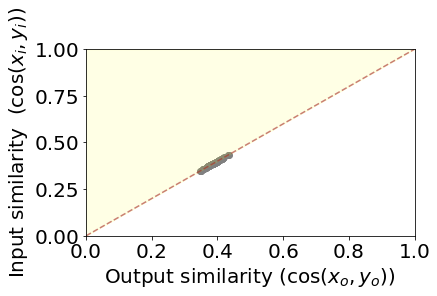

In [12]:
# there is no pattern separation of the inputs and outputs are the same
plot_pattern_separation(inputpattern, inputpattern) ;

In [13]:
I_network1 = randpattern(1000,.1) # 90% of neurons are active (are zeros)
I = I_network1
outpattern  = [(I*x, I*y) for x,y in inputpattern]

Proportion of separated patterns 0.5100


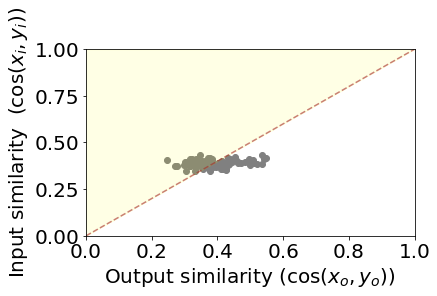

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
 
ax = plot_pattern_separation(inputpattern, outpattern)